# Population Dynamics and Theta Rhythm Phase Precession of  Hippocampal Place Cell Firing: A Spiking Neuron Model

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import hilbert

In [19]:
# J1 = 0.015       # maximum excitatory strength
# J2 = 0.02        # other strengthes
# l = 0.1         # decay constant of excitatory interactions
# Sigma = 1.8      # weights factor

# V_res = 0.85     # resting state of membrane potential
# V_th = 1.        # spike threshold
# tau_mem = 20.    # time constant of membrane potential
# tau_ex = 6.      # time constant of excitatory synaptic current
# tau_in = 4.      # time constant of inhibitory synaptic current
# S_ex = 0.25       # reliability of E synaptic transmission
# S_in = 0.8       # reliability of I synaptic transmission
# lambda_e = 0.035    # degree of place-specific E input modulation
# lambda_i = 0.035    # degree of place-specific I input modulation

# I0_ex = 1.015         # input current baseline
# I0_in = 1.06        # input current baseline
# T = 1000/9       # period of inhibitory input

# num_E = 400      # num of E neurons 
# num_I = 100      # num of I neurons 
# num_ALL = num_E+num_I # num of all neurons 

# time_MOVING = 4000 # time of rat moving
# dt = 2             # time step for simulation

# rand_choices = [0, 1]

In [80]:
J1 = 0.015       # maximum excitatory strength
J2 = 0.02        # other strengthes
l = 0.15         # decay constant of excitatory interactions
Sigma = 1.8      # weights factor

V_res = 0.85     # resting state of membrane potential
V_th = 1.        # spike threshold
tau_mem = 20.    # time constant of membrane potential
tau_ex = 6.      # time constant of excitatory synaptic current
tau_in = 4.      # time constant of inhibitory synaptic current
S_ex = 0.2       # reliability of E synaptic transmission
S_in = 0.7       # reliability of I synaptic transmission
lambda_e = 0.03    # degree of place-specific E input modulation
lambda_i = 0.02    # degree of place-specific I input modulation

I0_ex = 1.02         # input current baseline
I0_in = 1.02        # input current baseline
T = 1000/9       # period of inhibitory input

num_E = 800      # num of E neurons 
num_I = 200      # num of I neurons 
num_ALL = num_E+num_I # num of all neurons 

time_MOVING = 4000 # time of rat moving
dt = 2             # time step for simulation

rand_choices = [0, 0.5, 1]

## 1. Dynamics Definiation

**The synaptic interactions**

Between the pyramidal neurons:

$
J_{i j}^{e x}=\sigma_{i j} J_{1} \exp \left(-\frac{\left|x_{i}-x_{j}\right|}{l}\right)
$

$
\begin{aligned}
\sigma_{i j} &=1, & & i<j \\
&=\sigma, & & i>j
\end{aligned}
$

For inhibitory hippocampal neurons, their connections with each other and with the excitatory neurons are uniform,




In [81]:
def get_ee_w(sigma, xi, xj):
    return sigma*J1*np.exp(-np.abs(xi-xj)/l)

**Dynamics of the membrane potential of each neuron**

$
\tau \frac{d V_{i}}{d t}=-V_{i}+I_{i}^{s}(t)+I_{i}^{e x t}(t)
$

$
I^{s}(t)=I^{e x}(t)-I^{i n}(t)
$

In [82]:
def fr_sigmoid(v):
    return 1 / (1 + np.exp(-x))

def get_avg_mem_dv(v, i):
    return (-v+i)/tau_mem

**E/I synaptic current**

$
\frac{d I_{i}^{e x}(t)}{d t}=-\frac{I_{i}^{ex}(t)}{\tau^{e x}}+s^{ex}(t) \sum_{j} J_{i j}^{e x} \delta\left(t-t_{j}^{ex}\right)
$

$
\frac{d I_{i}^{i n}(t)}{d t}=-\frac{I_{i}^{i n}(t)}{\tau^{i n}}+s^{i n}(t) \sum_{j} J_{i j}^{i n} \delta\left(t-t_{j}^{i n}\right)
$

In [83]:
def get_syn_di(i, syn_tau, s, Jij, spike_j):
    i_decay = -i/syn_tau 
    i_rec =  s*np.dot(Jij, spike_j)
    return i_decay + i_rec

**External Inputs**

$
I_{i}^{e x t}(t)=I_{0}\left(1+\lambda_{e} \exp \left(-\frac{\left|x_{i}-x_{0}(t)\right|}{l}\right)\right)
$

$
I_{i}^{ext}(t)=I_{0}\left(1+\lambda_{i} \cos (2 \pi t / T)\right)
$

In [84]:
def get_ext_e_i(xi, x0_t):
    return I0_ex*(1+lambda_e*np.exp(-np.abs(xi-x0_t)/l))

def get_ext_i_i(t, period):
    return I0_in*(1+lambda_i*np.cos(2*np.pi*t/period))

**The traversal of the apparatus in 4000 ms by the rat moving with a constant speed**

$x_{0}(t)=t / 4000$

In [85]:
def get_x0(t, tot_time):
    return t/tot_time

## 2. Network Definiation & Initialization 

### 2.1 Position Labels

In [86]:
def get_position_labels(max_p=1):
    return np.linspace(0,max_p,num_E)

### 2.2 Recurrent Synaptic Strengthes

In [87]:
def init_rec_w(x_labels):
    W_rec = np.ones((num_ALL, num_ALL))*J2

    for i in range(num_E):
        for j in range(num_E):
            sigma_ij = 1 if i<j else Sigma
            W_rec[i][j] = get_ee_w(sigma=sigma_ij, xi=x_labels[i],xj=x_labels[j])

    np.fill_diagonal(W_rec, 0.)

    return W_rec

### 2.3 Network Configuration

In [88]:
class ThetaRhythmSpikeNetwork():
    def __init__(self,tot_time=time_MOVING, ext_t=T):
        self.tot_time = tot_time
        self.x_labels = get_position_labels(1.)
        self.W_rec = init_rec_w(self.x_labels)
        self.time_map = np.arange(0, tot_time, dt)
        self.step_num = len(self.time_map)
        self.Vs = np.zeros((num_ALL, self.step_num))
        self.Vs[:,0] = V_res
        self.Is = np.zeros((num_ALL, self.step_num))
        self.I_exs = np.zeros((num_ALL, self.step_num))
        self.I_ins = np.zeros((num_ALL, self.step_num))
        self.Ss = np.zeros((num_ALL, self.step_num))

        self.ext_t = ext_t

    def simulation(self,):
        for curr_ts in range(1, self.step_num):
            curr_x0 = get_x0(self.time_map[curr_ts], self.tot_time)

            for n in range(0, num_ALL):
                prev_iex = self.I_exs[n, curr_ts-1]
                prev_iin = self.I_ins[n, curr_ts-1]
                prev_In = self.Is[n, curr_ts-1]
                prev_v = self.Vs[n, curr_ts-1]
                prev_s = self.Ss[:, curr_ts-1]

                curr_s_ex = np.random.choice(rand_choices)*S_ex
                curr_s_in = np.random.choice(rand_choices)*S_in

                if n < num_E:
                    curr_i_ext = get_ext_e_i(xi=self.x_labels[n], x0_t=curr_x0)
                else:
                    curr_i_ext = get_ext_i_i(self.time_map[curr_ts],period=self.ext_t)

                curr_i_ex = dt*get_syn_di(prev_iex, tau_ex, curr_s_ex, 
                                       self.W_rec[n,:num_E], prev_s[:num_E])+prev_iex
                curr_i_in = dt*get_syn_di(prev_iin, tau_in, curr_s_in, 
                                       self.W_rec[n,num_E:], prev_s[num_E:])+prev_iin

                curr_i = curr_i_ex-curr_i_in+curr_i_ext

                self.Is[n,curr_ts]=curr_i
                self.I_exs[n, curr_ts] = curr_i_ex
                self.I_ins[n, curr_ts] = curr_i_in

                curr_v = dt*get_avg_mem_dv(v=prev_v, i=curr_i)+prev_v
                
                if curr_v >= V_th:
                    self.Vs[n, curr_ts] = V_res
                    self.Ss[n, curr_ts] = 1.
                else:
                    self.Vs[n, curr_ts] = curr_v
                    self.Ss[n, curr_ts] = 0.


In [89]:
class ThetaRhythmRefSpikeNetwork(ThetaRhythmSpikeNetwork):
    def __init__(self, tot_time=time_MOVING, ext_t=T, ref_t=6):
        super().__init__(tot_time=tot_time, ext_t=ext_t)
        self.refs = np.zeros(num_ALL)
        self.ref_ts = int(ref_t/dt)
        
    def simulation(self,):
        for curr_ts in range(1, self.step_num):
            curr_x0 = get_x0(self.time_map[curr_ts], self.tot_time)

            for n in range(0, num_ALL):
                prev_iex = self.I_exs[n, curr_ts-1]
                prev_iin = self.I_ins[n, curr_ts-1]
                prev_In = self.Is[n, curr_ts-1]
                prev_v = self.Vs[n, curr_ts-1]
                prev_s = self.Ss[:, curr_ts-1]

                curr_s_ex = np.random.choice(rand_choices)*S_ex
                curr_s_in = np.random.choice(rand_choices)*S_in

                if n < num_E:
                    curr_i_ext = get_ext_e_i(xi=self.x_labels[n], x0_t=curr_x0)
                else:
                    curr_i_ext = get_ext_i_i(self.time_map[curr_ts],period=self.ext_t)

                curr_i_ex = dt*get_syn_di(prev_iex, tau_ex, curr_s_ex, 
                                       self.W_rec[n,:num_E], prev_s[:num_E])+prev_iex
                curr_i_in = dt*get_syn_di(prev_iin, tau_in, curr_s_in, 
                                       self.W_rec[n,num_E:], prev_s[num_E:])+prev_iin

                curr_i = curr_i_ex-curr_i_in+curr_i_ext

                self.Is[n,curr_ts]=curr_i
                self.I_exs[n, curr_ts] = curr_i_ex
                self.I_ins[n, curr_ts] = curr_i_in

                curr_v = dt*get_avg_mem_dv(v=prev_v, i=curr_i)+prev_v
                
                if curr_v >= V_th:
                    if self.refs[n] == 0.:
                        self.Ss[n, curr_ts] = 1.
                        self.refs[n] = self.ref_ts
                    else:
                        self.refs[n] = self.refs[n]-1
                        
                    self.Vs[n, curr_ts] = V_res
                else:
                    self.Vs[n, curr_ts] = curr_v
                    self.Ss[n, curr_ts] = 0.



## 3. Simulation & Visualization

### 3.1 Single Trial Simulation

In [171]:
snn = ThetaRhythmRefSpikeNetwork(3000, ref_t=6)#ThetaRhythmSpikeNetwork(2000)#
snn.simulation()

In [172]:
def plot_spike_activity(sn, s_t, e_t):
    params = {'legend.fontsize': 'x-large',
            'figure.figsize': (10, 10),
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'}
    s_t = int(s_t/dt)
    e_t = int(e_t/dt)

    plt.rcParams.update(params)
    ss = sn.Ss[:,s_t:e_t]
    ts = np.arange(0, sn.step_num)[s_t:e_t]

    t_len = np.shape(ss)[1]
    spike_n, spike_t = np.where(ss[:num_E]==1.)
    fig, ax = plt.subplots(nrows=2, gridspec_kw={'hspace': 0.,'height_ratios': [3, 1]})
    
    ax[0].scatter(spike_t, spike_n, marker='o', color='black',s=20, linewidth=1)
    ax[1].plot([get_ext_i_i(sn.time_map[t],period=sn.ext_t) for t in ts])

    ax[0].set_ylim([0, num_E])
    ax[0].set_xlim([0, t_len])
    ax[0].set_xticks([]) 
    ax[1].set_xlim([0, t_len])
    plt.show()



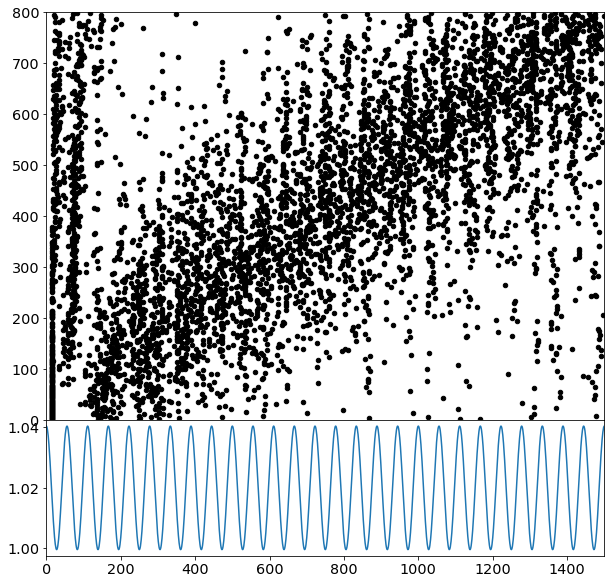

In [173]:
plot_spike_activity(snn,0,3000)

In [500]:
# n_ids = list(range(100,104))
# tot_times = list(range(2000, time_MOVING+200, 200))
# spike_recording = []

# for tot_t in tot_times:
#     print('tot_t',tot_t)
#     for t in range(10):
#         print('record itr',t)
#         snn = ThetaRhythmSpikeNetwork(tot_t)
#         snn.simulation()
#         spike_recording.append(snn.Ss)

### 3.2 Phase VS Position

In [ ]:
tot_times = list(range(2000, 3600, 200))
itr_num = 100

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
colors = ['red', 'blue', 'orange', 'green']
n_ids = list(range(90,130,10))

for tot_t in tot_times:
#     print('tot_t',tot_t)
    snn = ThetaRhythmSpikeNetwork(tot_t)
    curr_spike_recording = []
    for itr in range(itr_num):
#         print('record itr',itr)
        curr_ss = np.load('/home/opc/disk/theta/spike_recording_totT'+str(tot_t)+'_itr'+str(itr)+'.npy')
        for index, n in enumerate(n_ids):
            curr_spike_t = np.where(curr_ss[n]==1.)[0]
#             curr_spike_t = curr_spike_t[curr_spike_t>100]
            if len(curr_spike_t)>0:
#                 print('curr_spike_t',curr_spike_t*dt)
                analytic_signal = hilbert(np.cos(2*np.pi*(curr_spike_t*dt)/T))
#                 print('radi',np.cos(2*np.pi*(curr_spike_t*dt)/T))
#                 print('analytic_signal', analytic_signal)
                curr_phase = (np.angle(analytic_signal, deg=True)+360)%360 
#                 print('curr_phase',curr_phase)
                curr_position = np.array([get_x0(snn.time_map[t], tot_t) for t in curr_spike_t])
                plt.scatter(curr_position, curr_phase, marker='o', color=colors[index],s=20, linewidth=1)
                
#                 filtered  = np.where( (curr_phase!=180) & (curr_phase!=0))[0]
#                 if len(filtered) >0:
#                     curr_phase = curr_phase[filtered]
#                     curr_position = np.array([get_x0(snn.time_map[t], tot_t) for t in curr_spike_t])
#                     curr_position = curr_position[filtered]
#                     plt.scatter(curr_position, curr_phase, marker='o', color=colors[index],s=20, linewidth=1)

plt.xlim([100, 250])
plt.xlim([0.1, .5])
plt.show()


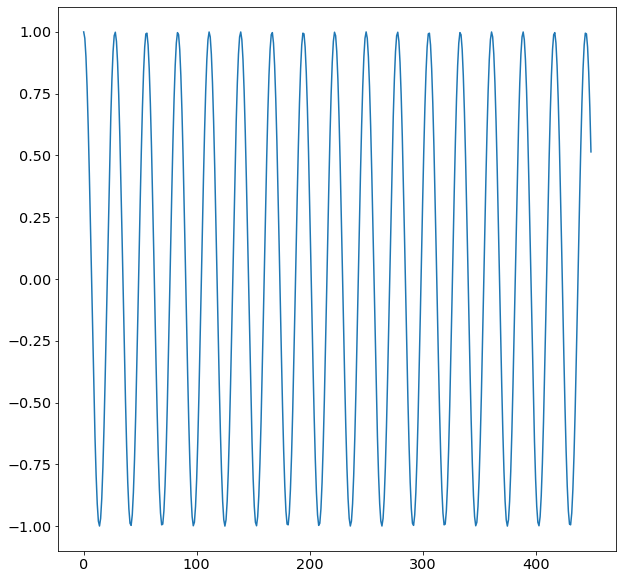

In [361]:
sig = np.cos(2*np.pi*(snn.time_map*dt/T))
hsig = hilbert(sig)

# sig[:10],hsig[:10]
# plt.plot(np.cos(2*np.pi*(snn.time_map*dt/T)))
plt.plot(sig)

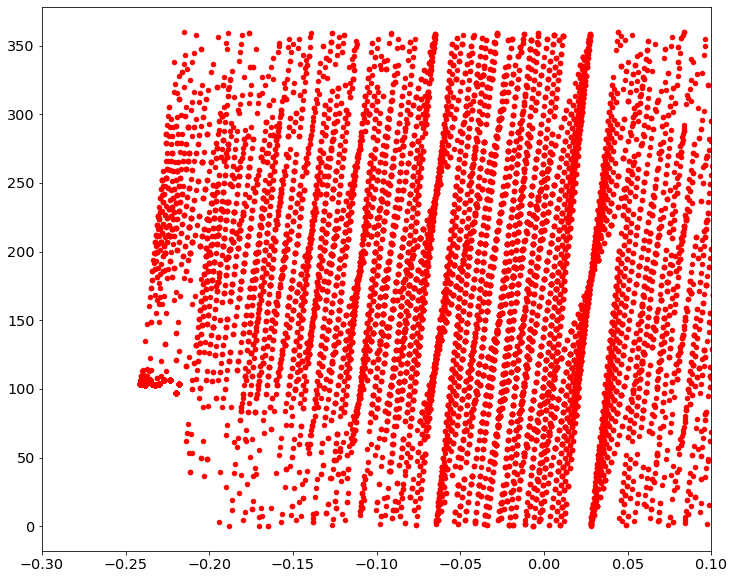

In [166]:
tot_times = list(range(1000, 3800, 200))
itr_num = 200

position_all = []
phase_all = []

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
colors = ['red', 'blue', 'orange', 'green','pink']
n_ids = [200]#list(range(200,280,20))#[250]#list(range(200,205))#[220]#list(range(200,300,25))

for tot_t in tot_times:

    snn = ThetaRhythmSpikeNetwork(tot_t)
    analytic_signal = hilbert(np.cos(2*np.pi*snn.time_map/T))
    
    curr_spike_recording = []
    curr_spike_ts = [[]]*len(n_ids)
    for itr in range(itr_num):

        curr_ss = np.load('/home/opc/disk/0129/spike_recording_totT'+str(tot_t)+'_itr'+str(itr)+'.npy')
        
        for index, n in enumerate(n_ids):
            curr_spike_t = np.where(curr_ss[n]==1.)[0] 
#             print(curr_spike_t)
            curr_spike_ts[index] = curr_spike_ts[index] + curr_spike_t.tolist()
    
    for index in range(len(n_ids)):
        curr_spike_time = np.array(curr_spike_ts[index])
        cord_x = n_ids[index]/num_E
        curr_position = np.array([get_x0(snn.time_map[t], snn.tot_time)-cord_x for t in curr_spike_time])
#         curr_spike_time = np.array(curr_spike_ts[index])#.astype(float)
#         analytic_signal = hilbert(np.cos(2*np.pi*(curr_spike_time*dt%tot_t/T)))
        curr_phase = (np.angle(analytic_signal[curr_spike_time], deg=True))%360 
#         print(np.shape(analytic_signal))
        
        plt.scatter(curr_position, curr_phase, marker='o', color=colors[index],s=20, linewidth=1)
        position_all.extend(curr_position)
        phase_all.extend(curr_phase)
        


# plt.ylim([0, 200])
plt.xlim([-0.3, 0.1])
plt.show()

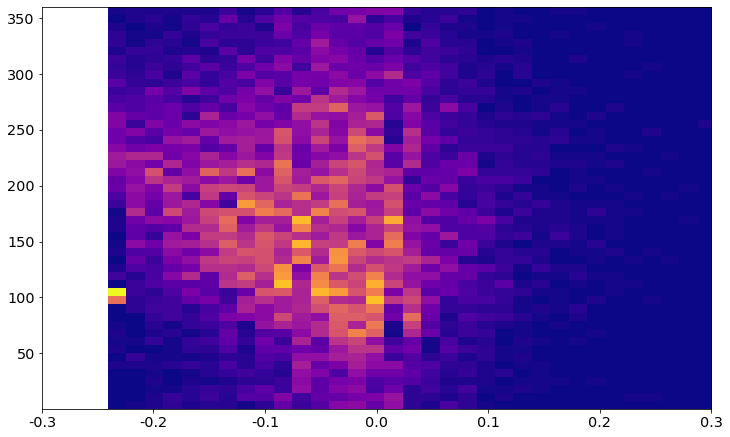

In [170]:
# print(len(phase_all))
from  matplotlib.ticker import FuncFormatter
heatmap, xedges, yedges = np.histogram2d(np.array(position_all)*1000, phase_all, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap[1:].T, extent=extent, origin='lower', cmap='plasma')#, interpolation='gaussian'
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(float(x)/1000, ',')))
plt.xlim(np.array([-0.3, 0.3])*1000)
plt.show()

In [151]:
np.shape()
# print(curr_spike_time.tolist())
# plt.plot(analytic_signal)
# t_t =  [16, 196, 312, 346, 403, 483, 533, 553, 594, 638, 662, 748, 797]
# plt.scatter(t_t, analytic_signal[t_t])
# print(curr_position)

(25, 25)

In [ ]:
import math
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
colors = ['red', 'blue', 'orange', 'green']
n_ids = list(range(90,130,10))
# n_ids = list(range(100,104))
i = 0
for tot_t in tot_times:
#     print('tot_t',tot_t)
    snn = ThetaRhythmSpikeNetwork(tot_t)
    for _ in range(10):
        for index, n in enumerate(n_ids):
            curr_spike_t = np.where(spike_recording[i][n]==1.)[0]
            curr_spike_t = curr_spike_t[curr_spike_t>100]
            if len(curr_spike_t)>0:
                analytic_signal = hilbert(np.cos(2*np.pi*(curr_spike_t*dt)/T)) 
                curr_phase = (np.angle(analytic_signal, deg=True)+360)%360 
                filtered  = np.where( (curr_phase!=180) & (curr_phase!=0))[0]


                if len(filtered) >0:
                    curr_phase = curr_phase[filtered]
                    curr_position = np.array([get_x0(snn.time_map[t], tot_t) for t in curr_spike_t])
                    curr_position = curr_position[filtered]
                    plt.scatter(curr_position, curr_phase, marker='o', color='black',s=20, linewidth=1)
#                     plt.scatter(curr_position, curr_phase, marker='o', color=colors[index],s=20, linewidth=1)
#             break
        i =1+i

plt.xlim([0.1, .5])
plt.show()
        

In [ ]:
from scipy.signal import hilbert
# np.shape(spike_recording[0][n_ids])
spike_n, spike_t = np.where(spike_recording[0][n_ids]==1.)
analytic_signal = hilbert(np.cos(2*np.pi*(spike_t*dt)/T))
phase = np.angle(analytic_signal, deg=True)

# phase =  np.degrees(np.cos(2*np.pi*(spike_t*dt)/T))%360# np.degrees((spike_t*dt)%T/T)
# spike_t
snn = ThetaRhythmSpikeNetwork(2000)
[get_x0(snn.time_map[t], 2000) for t in spike_t]
# print(np.cos(2*np.pi*(spike_t*dt)/T))
phase, spike_t
# import json
# with open("spike_recording.txt", "w") as fp:
#     json.dump([r.tolist() for r in spike_recording], fp)

In [ ]:
# test_n, test_t = np.where(spike_recording[0][n_ids]==1.)

# sn = ThetaRhythmSpikeNetwork(2000)
# plt.scatter(spike_t, phase, marker='o', color='black',s=20, linewidth=1)
# plt.vlines(spike_t, ymin=40, ymax=50)
plt.scatter(spike_t,np.cos(2*np.pi*(spike_t*dt)/T))
plt.plot(np.array([np.cos(2*np.pi*(t*dt)/T) for t in range(500)]))

In [ ]:
import math
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
colors = ['red', 'blue', 'orange', 'green']
n_ids = list(range(90,130,10))
# n_ids = list(range(100,104))
i = 0
for tot_t in tot_times:
#     print('tot_t',tot_t)
    snn = ThetaRhythmSpikeNetwork(tot_t)
    sig = hilbert(np.cos(2*np.pi*(snn.time_map*dt/T)))
    for _ in range(10):
        for index, n in enumerate(n_ids):
            curr_spike_t = np.where(spike_recording[i][n]==1.)[0]
            curr_spike_t = curr_spike_t[curr_spike_t>100]
            if len(curr_spike_t)>0:
                analytic_signal = hilbert(np.cos(2*np.pi*(curr_spike_t*dt)/T)) #+ np.random.randn(len(curr_spike_t))
                
#                 analytic_signal = analytic_signal +  np.random.randn(len(analytic_signal)).view(np.complex64)
                curr_phase = (np.angle(analytic_signal, deg=True)+360)%360 
                filtered  = np.where( (np.abs(curr_phase- 180)> 0.001) & (curr_phase!=0))[0]
#                 curr_phase = curr_phase[curr_phase!=180]
#                 print(filtered)

                if len(filtered) >0:
                    curr_phase = curr_phase[filtered]
                    curr_position = np.array([get_x0(snn.time_map[t], tot_t) for t in curr_spike_t])
                    curr_position = curr_position[filtered]
                    plt.scatter(curr_position, curr_phase, marker='o', color='black',s=20, linewidth=1)
#                     plt.scatter(curr_position, curr_phase, marker='o', color=colors[index],s=20, linewidth=1)
#             break
        i =1+i

plt.xlim([0.1, .5])
plt.show()
        

In [ ]:
# def get_phase_position(sn, n=100, s_cycle=5):
#     s_t = int(T*s_cycle/dt)
#     e_t = int(T*(s_cycle+2)/dt)
#     phase_map = np.linspace(0,720,e_t-s_t)
#     # spike_n, spike_t = np.where(ss[n,]==1.)
#     spike_t = np.where(sn.Ss[n,s_t:e_t]==1.)
#     degrees = phase_map[spike_t]
#     x0s = [get_x0(sn.time_map[ts+s_t]) for ts in spike_t]
#     print(degrees)
#     xn = sn.x_labels[n]
#     print(xn, x0s)
#     positions = x0s-xn
#     print(positions)

# get_phase_position(snn)
-180%360

In [ ]:
# np.shape(spike_recording)

In [ ]:
def get_phase_position_v2(sn,n,spike,s_cycle=5):
    phase_map = np.linspace(0,720,e_t-s_t)
    # spike_n, spike_t = np.where(ss[n,]==1.)
    spike_t = np.where(spike[s_t:e_t]==1.)
    degrees = phase_map[spike_t]
    x0s = [get_x0(sn.time_map[ts+s_t]) for ts in spike_t]
    xn = sn.x_labels[n]
    positions = x0s-xn
    return positions, degrees

In [ ]:
get_phase_position_v2(snn, 100, spike_recording[0,0])

# n_ids

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
colors = ['red', 'blue', 'orange', 'yellow']

for index, n in enumerate(n_ids):
    for trial in spike_recording[index]:
        positions, degrees=  get_phase_position_v2(snn, n, trial)
        plt.scatter(positions, degrees, marker='o', color=colors[index],s=20, linewidth=1)
plt.show()

In [ ]:
def plot_current(n, nn):
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    plt.plot(nn.Is[n,],label='I')
    plt.plot(nn.I_exs[n,],label='I_ex')
    plt.plot(-nn.I_ins[n,],label='I_in')
    plt.legend()
    plt.show()

def plot_voltage(n, nn):
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    plt.plot(nn.Vs[n,],label='V')
    plt.legend()
    plt.show()